# 03 - Metabolic Flux Estimation

This notebook demonstrates metabolic flux estimation using scFEA (single-cell Flux Estimation Analysis).

## Overview

scFEA is a graph neural network-based tool designed specifically for estimating metabolic flux from scRNA-seq data. Unlike traditional FBA approaches, scFEA:
- Uses machine learning trained on known metabolic networks
- Predicts cell-specific flux values from gene expression
- Works with sparse scRNA-seq data
- Focuses on 719 curated metabolic genes

Steps include:
1. Load annotated single-cell data
2. Prepare expression matrix for scFEA
3. Run scFEA flux estimation
4. Analyze cell type-specific metabolism
5. Compare metabolic profiles

## Setup

In [14]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import subprocess
from pathlib import Path

# Configure
sc.settings.verbosity = 1

print(f"Scanpy version: {sc.__version__}")
print("\nNote: scFEA runs as a command-line tool. This notebook prepares data and calls scFEA.")

Scanpy version: 1.11.5

Note: scFEA runs as a command-line tool. This notebook prepares data and calls scFEA.


C:\Users\dell\AppData\Local\Temp\ipykernel_40184\3659820803.py:14: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


In [15]:
# Add suffix for updated output names
suffix = "estrus.23.01.26"

## Load Configuration and Data

In [16]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load annotated data
adata = sc.read_h5ad(f"../data/processed/{suffix}/annotated_data.h5ad")

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type'].nunique()}")
adata

Loaded data: 2815 cells x 21647 genes
Cell types: 14


AnnData object with n_obs × n_vars = 2815 × 21647
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'n_genes', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

## Prepare Expression Matrix for scFEA

scFEA requires:
- Expression matrix: genes (rows) × cells (columns)
- Gene names matching scFEA's metabolic gene list
- Values: normalized, log-transformed expression

In [17]:
# Load scFEA metabolic gene list
scfea_genes = pd.read_csv('../data/reference/scFEA_metabolic_genes.csv', header=0).iloc[:, 0].tolist()
print(f"scFEA metabolic genes: {len(scfea_genes)}")

# Check overlap with our data
genes_in_data = [g for g in scfea_genes if g in adata.var_names]
print(f"Genes found in dataset: {len(genes_in_data)} ({100*len(genes_in_data)/len(scfea_genes):.1f}%)")
print(f"Missing genes: {len(scfea_genes) - len(genes_in_data)}")

# Get expression matrix for scFEA genes only
if 'log1p_norm' in adata.layers:
    expr_matrix = adata[:, genes_in_data].layers['log1p_norm'].toarray()
else:
    expr_matrix = adata[:, genes_in_data].X.toarray()

# Create DataFrame: genes (rows) × cells (columns)
expr_df = pd.DataFrame(
    expr_matrix.T,  # Transpose to genes × cells
    index=genes_in_data,
    columns=adata.obs_names
)

print(f"\nExpression matrix shape: {expr_df.shape}")
print(f"  Genes (rows): {expr_df.shape[0]}")
print(f"  Cells (columns): {expr_df.shape[1]}")

scFEA metabolic genes: 719
Genes found in dataset: 579 (80.5%)
Missing genes: 140

Expression matrix shape: (579, 2815)
  Genes (rows): 579
  Cells (columns): 2815


## Export Data for scFEA

Save expression matrix in format required by scFEA.

In [18]:
# Create scFEA output directory
scfea_dir = Path(f'../results/scfea/{suffix}')
scfea_dir.mkdir(parents=True, exist_ok=True)

# Save expression matrix for scFEA
# scFEA expects: genes (rows) × cells (columns), CSV format
expr_file = scfea_dir / 'expression_input.csv'
expr_df.to_csv(expr_file)
print(f"Saved expression matrix to: {expr_file}")

# Save cell metadata for later analysis
metadata_file = scfea_dir / 'cell_metadata.csv'
adata.obs[['cell_type']].to_csv(metadata_file)
print(f"Saved cell metadata to: {metadata_file}")

print(f"\nExpression matrix: {expr_df.shape[0]} genes × {expr_df.shape[1]} cells")
print(f"Ready for scFEA analysis!")

Saved expression matrix to: ..\results\scfea\estrus.23.01.26\expression_input.csv
Saved cell metadata to: ..\results\scfea\estrus.23.01.26\cell_metadata.csv

Expression matrix: 579 genes × 2815 cells
Ready for scFEA analysis!


## Run scFEA

scFEA runs as a command-line tool. You can run it in terminal or from this notebook.

In [13]:
# scFEA usage instructions

print("=" * 70)
print("scFEA Usage")
print("=" * 70)

print("\nSTEP 0: Install scFEA Dependencies")
print("-" * 70)
print("First, install required packages:")
print()
print("pip install torch torchvision")
print("pip install scikit-learn pandas numpy")
print("pip install python-magic-bin")
print()
print("NOTE: This may take a few minutes")
print()

print("STEP 1: Navigate to scFEA directory")
print("-" * 70)
print("  cd Z:/thornes/Pavlicev_lab_rotation/scFEA")
print()

print("STEP 2: Run scFEA")
print("-" * 70)
print("IMPORTANT: Make sure scFEA's data files are present!")
print()
print("Check that these files exist in scFEA/data/:")
print("  - module_gene_m168.csv")
print("  - cmMat_c70_m168.csv")
print("  - (other .csv files)")
print()
print("For PowerShell (Windows), use backticks for line continuation:")
print()
print("python src/scFEA.py `")
print("    --data_dir data `")
print("    --input_dir ../FLUXestimator/results/scfea `")  
print("    --res_dir ../FLUXestimator/results/scfea `")
print("    --test_file expression_input.csv `")
print("    --moduleGene_file module_gene_complete_mouse_m168.csv")
print()
print("OR run on one line:")
print("$env:KMP_DUPLICATE_LIB_OK="TRUE"; cd Z:\thornes\Pavlicev_lab_rotation\scFEA; python src\scFEA.py --data_dir data --input_dir ../FLUXestimator/results/scfea/21.01.26 --res_dir ../FLUXestimator/results/scfea/21.01.26 --test_file expression_input.csv --moduleGene_file module_gene_complete_mouse_m168.csv")
print()

print("NOTES:")
print("  - This will take 10-30 minutes depending on dataset size")
print("  - GPU acceleration recommended (if available)")
print("  - Check scFEA README.md for all parameters")
print("  - scFEA outputs will be saved to results/scfea/")
print()

# Check if scFEA is cloned
scfea_path = Path("../../scFEA")
if scfea_path.exists():
    print(f"✓ scFEA found at: {scfea_path.absolute()}")
    
    # Check if scFEA.py exists
    scfea_py = scfea_path / "src" / "scFEA.py"
    if scfea_py.exists():
        print(f"✓ scFEA.py found at: {scfea_py}")
    else:
        print(f"⚠ scFEA.py not found at expected location")
else:
    print(f"⚠ scFEA not found. Clone it first with:")
    print("  cd Z:/thornes/Pavlicev_lab_rotation")
    print("  git clone https://github.com/changwn/scFEA.git")

scFEA Usage

STEP 0: Install scFEA Dependencies
----------------------------------------------------------------------
First, install required packages:

pip install torch torchvision
pip install scikit-learn pandas numpy
pip install python-magic-bin

NOTE: This may take a few minutes

STEP 1: Navigate to scFEA directory
----------------------------------------------------------------------
  cd Z:/thornes/Pavlicev_lab_rotation/scFEA

STEP 2: Run scFEA
----------------------------------------------------------------------
IMPORTANT: Make sure scFEA's data files are present!

Check that these files exist in scFEA/data/:
  - module_gene_m168.csv
  - cmMat_c70_m168.csv
  - (other .csv files)

For PowerShell (Windows), use backticks for line continuation:

python src/scFEA.py `
    --data_dir data `
    --input_dir ../FLUXestimator/results/scfea `
    --res_dir ../FLUXestimator/results/scfea `
    --test_file expression_input.csv `
    --moduleGene_file module_gene_complete_mouse_m168.csv


In [19]:
# After running scFEA, load the results
# scFEA outputs flux predictions for each cell

# Check if scFEA results exist - scFEA uses timestamped filenames
flux_files = list(scfea_dir.glob('*module168*.csv'))

if flux_files:
    flux_file = flux_files[0]  # Use the most recent one
    print(f"Loading scFEA flux predictions from: {flux_file.name}")
    flux_results = pd.read_csv(flux_file, index_col=0)
    
    print(f"Flux predictions shape: {flux_results.shape}")
    print(f"  Cells (rows): {flux_results.shape[0]}")
    print(f"  Metabolic modules (columns): {flux_results.shape[1]}")
    
    # Merge with cell type annotations
    cell_metadata = pd.read_csv(metadata_file, index_col=0)
    
    print("\nFlux results loaded successfully!")
    print(f"Preview:\n{flux_results.iloc[:5, :5]}")
else:
    print("⚠️ scFEA results not found.")
    print(f"Looking for files matching: *module168*.csv")
    print("\nPlease run scFEA first using the command above.")
    print("After scFEA completes, re-run this cell to load results.")

Loading scFEA flux predictions from: expression_input_module168_cell2815_batch2815_LR0.008_epoch100_SCimpute_F_lambBal1_lambSca1_lambCellCor1_lambModCor_1e-2_20260123-124945.csv
Flux predictions shape: (2815, 168)
  Cells (rows): 2815
  Metabolic modules (columns): 168

Flux results loaded successfully!
Preview:
                         M_1       M_2           M_3       M_4       M_5
AAACCCACAGCTGAAG-1  0.016516  0.022147 -1.252815e-05  0.002918  0.017667
AAACCCAGTGATGGCA-1  0.016572  0.029288 -3.054738e-06  0.002552  0.020339
AAACCCATCCATTCGC-1  0.020264  0.035231  3.213063e-08  0.005583  0.024900
AAACCCATCTCATTGT-1  0.016516  0.026297 -4.464760e-06  0.002471  0.019305
AAACGAAAGCGTACAG-1  0.017145  0.036115  7.848069e-05  0.005729  0.018057


## Analyse Results

In [20]:
# Analyse scFEA results by cell type
if flux_files:
    # scFEA output format: cells (rows) × metabolic modules (columns)
    flux_by_cell = flux_results.copy()
    flux_by_cell.index.name = 'cell_barcode'
    
    # Add cell type information
    flux_by_cell = flux_by_cell.join(cell_metadata['cell_type'], how='left')
    
    # Calculate mean flux per cell type
    mean_flux_by_type = flux_by_cell.groupby('cell_type').mean()
    
    print("Mean metabolic flux by cell type:")
    print(mean_flux_by_type.iloc[:5, :5])
    
    # Calculate cell type-specific metabolic activity
    total_flux = flux_by_cell.drop('cell_type', axis=1).abs().sum(axis=1)
    flux_summary = pd.DataFrame({
        'cell_type': flux_by_cell['cell_type'],
        'total_flux': total_flux
    })
    
    summary_stats = flux_summary.groupby('cell_type')['total_flux'].agg(['mean', 'median', 'std'])
    summary_stats = summary_stats.sort_values('mean', ascending=False)
    
    print("\nMetabolic activity summary by cell type:")
    print(summary_stats.round(3))
else:
    print("Run scFEA first to generate flux predictions.")

Mean metabolic flux by cell type:
                                         M_1       M_2       M_3       M_4  \
cell_type                                                                    
Dendritic Immune Cells              0.018046  0.028345  0.000216  0.006869   
Fibroblast Cells                    0.018206  0.026759  0.000061  0.005032   
Fibroblasts: Clec3b+ (outer/basal)  0.019284  0.027994  0.000094  0.006744   
Ignore                              0.016903  0.032723  0.000886  0.007281   
Inner Fibroblast Cells              0.016891  0.028518  0.000066  0.005311   

                                         M_5  
cell_type                                     
Dendritic Immune Cells              0.019859  
Fibroblast Cells                    0.019829  
Fibroblasts: Clec3b+ (outer/basal)  0.019891  
Ignore                              0.022821  
Inner Fibroblast Cells              0.019743  

Metabolic activity summary by cell type:
                                            mean

C:\Users\dell\AppData\Local\Temp\ipykernel_40184\806434750.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_for_box, labels=cell_types, vert=False, patch_artist=True)


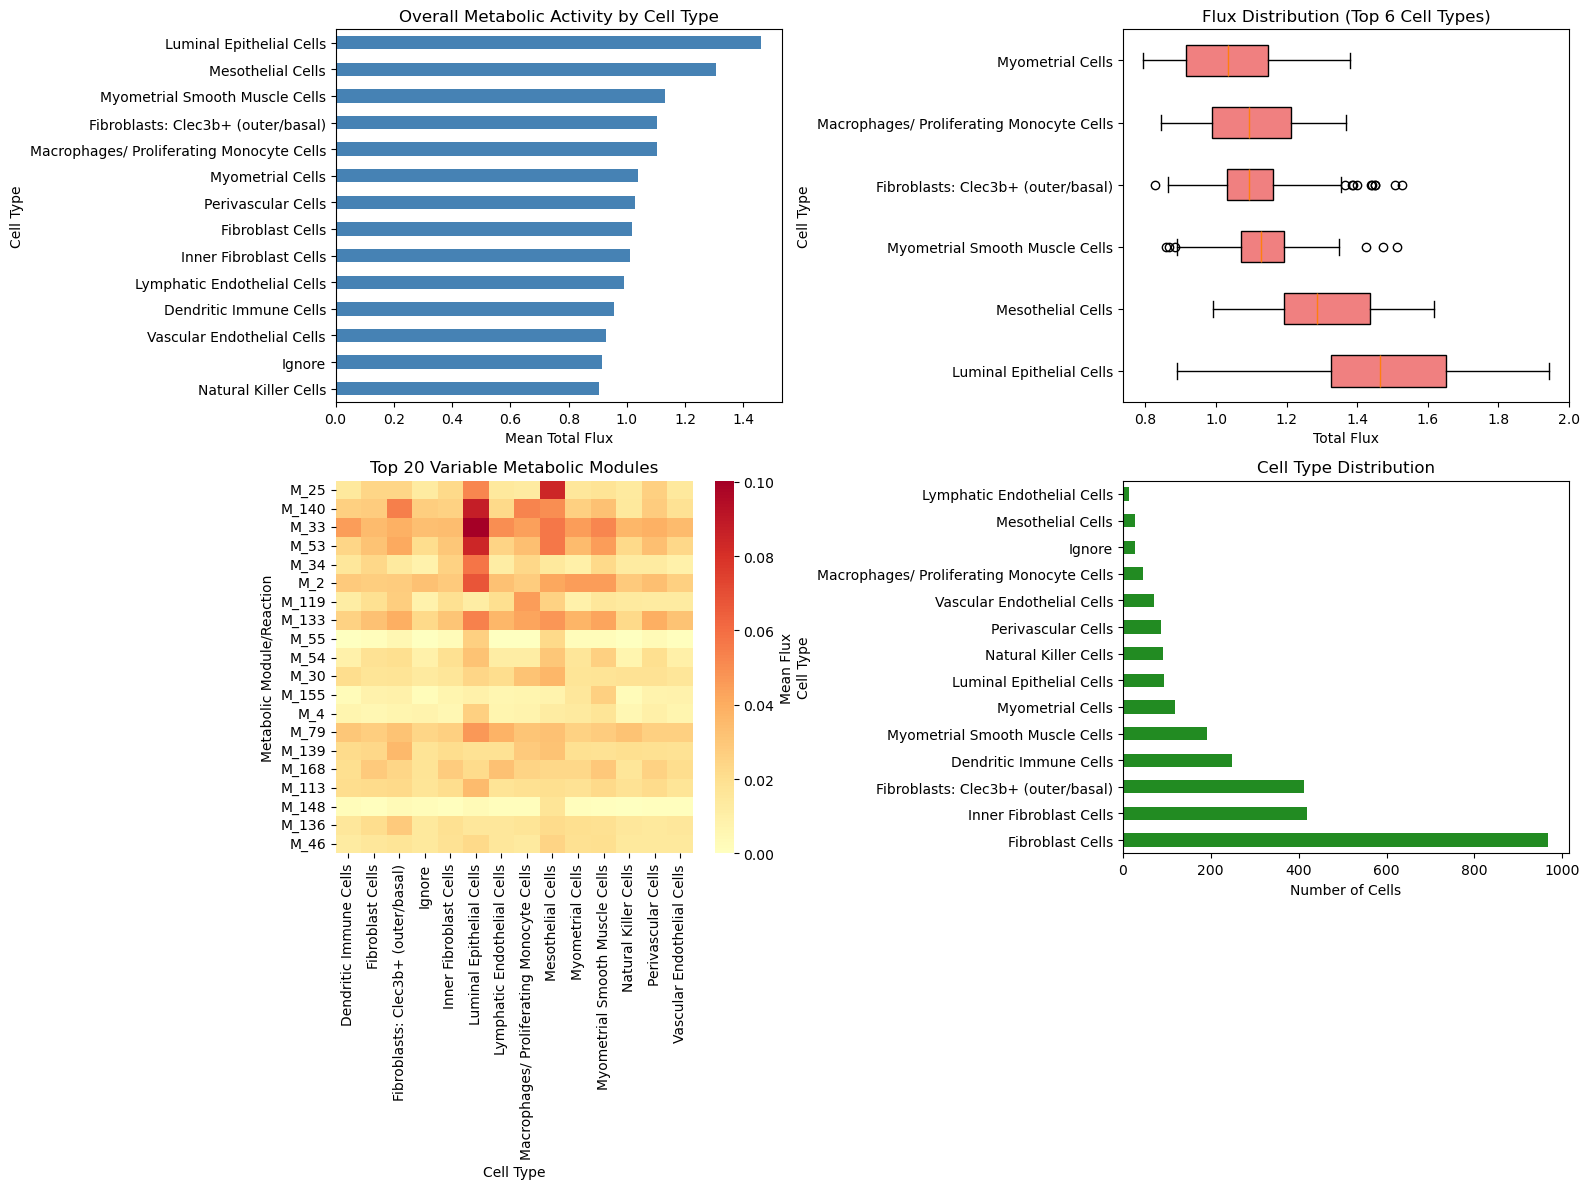


✓ Visualization complete!


In [21]:
# Visualize scFEA results
if flux_files:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Total flux per cell type
    summary_stats.sort_values('mean')['mean'].plot(kind='barh', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_xlabel('Mean Total Flux')
    axes[0, 0].set_ylabel('Cell Type')
    axes[0, 0].set_title('Overall Metabolic Activity by Cell Type')
    
    # 2. Distribution of total flux
    cell_types = summary_stats.index[:6]  # Top 6 cell types
    data_for_box = [flux_summary[flux_summary['cell_type'] == ct]['total_flux'].values for ct in cell_types]
    bp = axes[0, 1].boxplot(data_for_box, labels=cell_types, vert=False, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightcoral')
    axes[0, 1].set_xlabel('Total Flux')
    axes[0, 1].set_ylabel('Cell Type')
    axes[0, 1].set_title('Flux Distribution (Top 6 Cell Types)')
    
    # 3. Heatmap of top variable metabolic modules
    variance_per_module = mean_flux_by_type.var(axis=0).sort_values(ascending=False)
    top_modules = variance_per_module.head(20).index
    
    sns.heatmap(mean_flux_by_type[top_modules].T, cmap='RdYlBu_r', center=0,
                cbar_kws={'label': 'Mean Flux'}, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Cell Type')
    axes[1, 0].set_ylabel('Metabolic Module/Reaction')
    axes[1, 0].set_title('Top 20 Variable Metabolic Modules')
    
    # 4. Cell count per type
    flux_by_cell['cell_type'].value_counts().plot(kind='barh', ax=axes[1, 1], color='forestgreen')
    axes[1, 1].set_xlabel('Number of Cells')
    axes[1, 1].set_ylabel('Cell Type')
    axes[1, 1].set_title('Cell Type Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete!")
else:
    print("Run scFEA first to generate flux predictions.")

## Save Results

In [22]:
# Save processed results
if flux_files:
    tab_output_dir = f'../results/tables/{suffix}'
    os.makedirs(tab_output_dir, exist_ok=True)
    # Save cell type-specific flux summaries
    output_file = f'{tab_output_dir}/flux_by_celltype.csv'
    mean_flux_by_type.to_csv(output_file)
    print(f"Saved cell type flux profiles to: {output_file}")
    
    # Save summary statistics
    summary_file = f'{tab_output_dir}/flux_summary.csv'
    summary_stats.to_csv(summary_file)
    print(f"Saved flux summary statistics to: {summary_file}")
    
    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    print(f"Cell types analyzed: {len(mean_flux_by_type)}")
    print(f"Total cells: {len(flux_by_cell)}")
    print(f"Metabolic modules/reactions: {flux_results.shape[0]}")
    print(f"\nTop 5 metabolically active cell types:")
    for i, (ct, stats) in enumerate(summary_stats.head().iterrows(), 1):
        print(f"  {i}. {ct}: {stats['mean']:.2f} (mean flux)")
else:
    print("Run scFEA first to generate results.")

Saved cell type flux profiles to: ../results/tables/estrus.23.01.26/flux_by_celltype.csv
Saved flux summary statistics to: ../results/tables/estrus.23.01.26/flux_summary.csv

RESULTS SUMMARY
Cell types analyzed: 14
Total cells: 2815
Metabolic modules/reactions: 2815

Top 5 metabolically active cell types:
  1. Luminal Epithelial Cells: 1.46 (mean flux)
  2. Mesothelial Cells: 1.30 (mean flux)
  3. Myometrial Smooth Muscle Cells: 1.13 (mean flux)
  4. Fibroblasts: Clec3b+ (outer/basal): 1.10 (mean flux)
  5. Macrophages/ Proliferating Monocyte Cells: 1.10 (mean flux)


## Next Steps

**Important: Install and run scFEA before proceeding:**

1. Install scFEA:
   ```bash
   pip install scFEA
   ```

2. Run scFEA (use command from cell above)

3. Once complete, proceed to `04_visualization.ipynb` for comprehensive analysis

### About scFEA

scFEA (single-cell Flux Estimation Analysis) is a graph neural network-based method that:
- Predicts metabolic flux from scRNA-seq data
- Uses 719 curated metabolic genes
- Accounts for reaction stoichiometry and constraints
- Provides cell-specific flux estimates

**Reference:** Alghamdi et al. (2021) "A graph neural network model to estimate cell-wise metabolic flux using single-cell RNA-seq data" *Genome Research*